In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [6]:
import sys
sys.path.append("../../../") 

from utils.paths import make_dir_line

modality = 'c'
project = 'Database Design'
data = make_dir_line(modality, project)

raw = data('raw')
processed = data('processed')
external = data('external')

In [7]:
import sqlite3

conn = sqlite3.connect(external / 'database.sqlite')
cur = conn.cursor()

In [8]:
import sqlite3

def eliminar_vista(nombre_vista):
    try:

        # Consulta para eliminar la vista
        consulta = f"DROP VIEW IF EXISTS {nombre_vista};"

        # Ejecutar la consulta
        cur.execute(consulta)

        # Confirmar los cambios
        conn.commit()

        print(f"Vista '{nombre_vista}' eliminada correctamente.")

    except sqlite3.Error as error:
        print(f"Error al eliminar la vista: {error}")

# 7.3.0 Database Views

## 7.3.2 Tables vs views

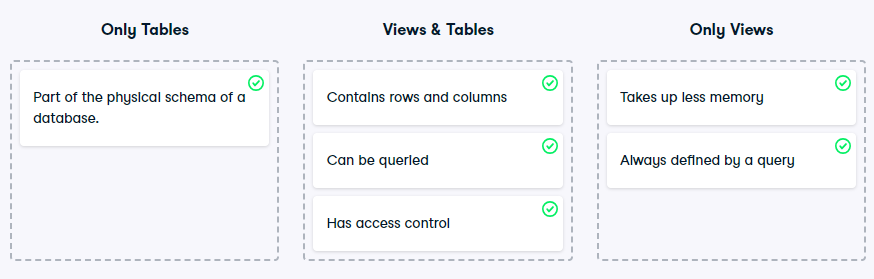

## 7.3.3 Viewing views

In [9]:
# -- Get all non-systems views  -> postgress
# cur.execute("""
            
#             SELECT * FROM information_schema.views
#             WHERE table_schema NOT IN ('pg_catalog', 'information_schema');

#             """).fetchall()

Question:

What does view1 do?

R:/ Returns the content records that have reviews of more than 4000 characters.

What does view2 do?

R:/ Returns the top 10 highest scored reviews published in 2017.

## 7.3.4 Creating and querying a view

In [10]:
# Llamar a la función para eliminar la vista
nombre_vista_a_eliminar = 'high_scores'
eliminar_vista(nombre_vista_a_eliminar)

Vista 'high_scores' eliminada correctamente.


In [11]:
# -- Create a view for reviews with a score above 9
cur.execute("""
            
            CREATE VIEW high_scores AS
            SELECT * 
            FROM reviews
            WHERE score > 9;

            """).fetchall()

[]

In [12]:
# -- Count the number of self-released works in high_scores
cur.execute("""
            
            SELECT COUNT(*) 
            FROM high_scores
            INNER JOIN labels ON high_scores.reviewid = labels.reviewid
            WHERE label = 'self-released';

            """).fetchall()

[(3,)]

## 7.3.6 Creating a view from other views

In [13]:
# Llamar a la función para eliminar la vista
nombre_vista_a_eliminar = 'top_15_2017'
eliminar_vista(nombre_vista_a_eliminar)

Vista 'top_15_2017' eliminada correctamente.


In [14]:
# -- Create a view top_15_2017 for exercise
cur.execute("""
            
            CREATE VIEW top_15_2017 AS
            SELECT reviews.reviewid,
                reviews.title,
                reviews.score
            FROM reviews
            WHERE (reviews.pub_year = 2017)
            ORDER BY reviews.score DESC
            LIMIT 15;

            """).fetchall()


[]

In [15]:
# Llamar a la función para eliminar la vista
nombre_vista_a_eliminar = 'artist_title'
eliminar_vista(nombre_vista_a_eliminar)

Vista 'artist_title' eliminada correctamente.


In [16]:
# -- Create a view artist_title for exercise
cur.execute("""
            
            CREATE VIEW artist_title AS
            SELECT reviews.reviewid,
                reviews.title,
                artists.artist
            FROM (reviews
                JOIN artists ON ((artists.reviewid = reviews.reviewid)));

            """).fetchall()

[]

In [17]:
# Llamar a la función para eliminar la vista
nombre_vista_a_eliminar = 'top_artists_2017'
eliminar_vista(nombre_vista_a_eliminar)

Vista 'top_artists_2017' eliminada correctamente.


In [18]:
# -- Create a view with the top artists in 2017, with only one column holding the artist field
cur.execute("""
            
            CREATE VIEW top_artists_2017 AS
            SELECT artist_title.artist FROM artist_title
            INNER JOIN top_15_2017
            ON artist_title.reviewid = top_15_2017.reviewid;

            """).fetchall()

[]

In [19]:
# -- Output the new view
cur.execute("""
            
            SELECT * 
            FROM top_artists_2017;

            """).fetchall()

[('massive attack',),
 ('krallice',),
 ('uranium club',),
 ('kleenex',),
 ('liliput',),
 ('taso',),
 ('various artists',),
 ('little simz',),
 ('yotam avni',),
 ('brian eno',),
 ('harry bertoia',),
 ('run the jewels',),
 ('steven warwick',),
 ('pete rock',),
 ('smoke dza',),
 ('various artists',),
 ('senyawa',)]

Question:

Which is the DROP command that would drop both top_15_2017 and top_artists_2017?

R:/ DROP VIEW top_15_2017 CASCADE;

In [20]:
# # -- Output the new view
# cur.execute("""
            
#             DROP VIEW top_15_2017 CASCADE;

#             """).fetchall()

## 7.3.7 Granting and revoking access

In [21]:
# Llamar a la función para eliminar la vista
nombre_vista_a_eliminar = 'long_reviews'
eliminar_vista(nombre_vista_a_eliminar)

Vista 'long_reviews' eliminada correctamente.


In [22]:
# -- Create a view with the top artists in 2017, with only one column holding the artist field
cur.execute("""
            
            CREATE VIEW long_reviews AS
            SELECT content.reviewid,
                   content.content
            FROM content
            WHERE (length(content.content) > 4000);

            """).fetchall()

[]

In [23]:
# # -- Revoke everyone's update and insert privileges
# cur.execute("""
            
#             REVOKE UPDATE, INSERT ON long_reviews FROM PUBLIC;

#             """).fetchall()

In [24]:
# # -- Grant the editor update and insert privileges 
# cur.execute("""
            
#             GRANT UPDATE, INSERT ON long_reviews TO editor; 

#             """).fetchall()

## 7.3.8 Updatable views

Which views are updatable?

R:/ long_reviews is updatable because it's made from one table and doesn't have any special clauses.

## 7.3.9 Redefining a view

The artist_title view needs to be appended to include a column for the label field from the labels table.

Question

Can the CREATE OR REPLACE statement be used to redefine the artist_title view?

R:/ Yes, as long as the label column comes at the end.

In [27]:
# Llamar a la función para eliminar la vista
nombre_vista_a_eliminar = 'artist_title'
eliminar_vista(nombre_vista_a_eliminar)

Vista 'artist_title' eliminada correctamente.


In [28]:
# -- Redefine the artist_title view to have a label column
cur.execute("""
            
            CREATE VIEW artist_title AS 
            SELECT reviews.reviewid, reviews.title, artists.artist, labels.label
            FROM reviews
            INNER JOIN artists
            ON artists.reviewid = reviews.reviewid
            INNER JOIN labels
            ON labels.reviewid = reviews.reviewid;

            """).fetchall()

# OR REPLACE

[]

In [29]:
cur.execute("""
            
            SELECT * FROM artist_title;

            """).fetchall()

[(22703, 'mezzanine', 'massive attack', 'virgin'),
 (22721, 'prelapsarian', 'krallice', 'hathenter'),
 (22659, 'all of them naturals', 'uranium club', 'fashionable idiots'),
 (22659, 'all of them naturals', 'uranium club', 'static shock'),
 (22661, 'first songs', 'kleenex', 'kill rock stars'),
 (22661, 'first songs', 'kleenex', 'mississippi'),
 (22661, 'first songs', 'liliput', 'kill rock stars'),
 (22661, 'first songs', 'liliput', 'mississippi'),
 (22725, 'new start', 'taso', 'teklife'),
 (22722,
  'insecure (music from the hbo original series)',
  'various artists',
  'rca'),
 (22704, 'stillness in wonderland', 'little simz', 'age 101'),
 (22694, 'tehillim', 'yotam avni', 'stroboscopic artefacts'),
 (22714, 'reflection', 'brian eno', 'warp'),
 (22724, 'filthy america its beautiful', 'the lox', 'roc nation'),
 (22715, 'clear sounds/perfetta', 'harry bertoia', 'important'),
 (22745, 'run the jewels 3', 'run the jewels', 'self-released'),
 (22700, 'nadir', 'steven warwick', 'pan'),
 (22

## 7.3.11 Materialized versus non-materialized

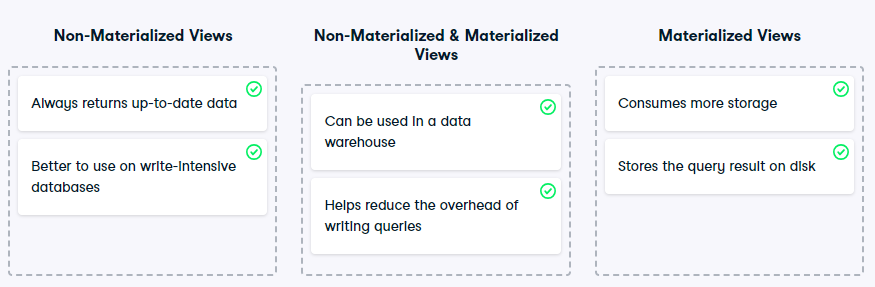

## 7.3.12 Creating and refreshing a materialized view

In [35]:
# # -- Create a materialized view called genre_count 
# cur.execute("""
            
#             CREATE MATERIALIZED VIEW genre_count AS
#             SELECT genre, COUNT(*) 
#             FROM genres
#             GROUP BY genre;

#             """).fetchall()

In [32]:
cur.execute("""
            
            INSERT INTO genres
            VALUES (50000, 'classical');

            """).fetchall()

[]

In [ ]:
# # -- Refresh genre_count
# cur.execute("""
            
#             REFRESH MATERIALIZED VIEW genre_count;

#             """).fetchall()

In [ ]:
# cur.execute("""
            
#             SELECT * 
#             FROM genre_count;

#             """).fetchall()

## 7.3.13 Managing materialized views

Why do companies use pipeline schedulers, such as Airflow and Luigi, to manage materialized views?

R:/ To refresh materialized views with consideration to dependences between views. These pipeline schedulers help visualize dependencies and create a logical order for refreshing views.

In [ ]:
print('Ok_')